In [ ]:
# Cell 1 — Setup
!pip -q install nltk sentence-transformers

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")

STOP_WORDS = set(stopwords.words("english"))
LEMM = WordNetLemmatizer()
RANDOM_STATE = 42


In [ ]:
# Cell 2 — Load data
from google.colab import drive
drive.mount("/content/drive")
df = pd.read_csv('/content/drive/MyDrive/Financial_Analysis/data/newest_invoices_data.csv')

print(df.shape)
df.head()


In [ ]:
# Cell 3 — Build a "financial document" per row (text + controlled numeric tokens)
def bin_amount(x: float) -> str:
    # bins keep numeric signal without leaking exact amounts
    if x < 200: return "amt_very_low"
    if x < 800: return "amt_low"
    if x < 2000: return "amt_mid"
    if x < 6000: return "amt_high"
    return "amt_very_high"

def build_document(row) -> str:
    parts = [
        f"service_{str(row['service']).strip()}",
        f"client_{str(row['client']).strip()}",
        f"status_{str(row['invoiceStatus']).strip()}",
        f"country_{str(row['country']).strip()}",
        f"total_{bin_amount(float(row['total']))}",
        f"tax_{bin_amount(float(row['tax']))}",
        f"discount_{bin_amount(float(row['discount']))}",
        f"balance_{bin_amount(float(row['balance']))}",
    ]
    return " ".join(parts)

df["doc_raw"] = df.apply(build_document, axis=1)
df["doc_raw"].head()


In [4]:
# Cell 4 — Define preprocessing pipelines P0–P3 (edit these to match your dissertation definitions)
def p0(text: str) -> str:
    # Minimal: lowercase + strip
    return str(text).lower().strip()

def p1(text: str) -> str:
    # Basic cleaning: keep underscores, remove other punctuation
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9_\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def p2(text: str) -> str:
    # P1 + stopword removal (stopwords will have limited effect here, but kept for objective completeness)
    text = p1(text)
    toks = [t for t in text.split() if t not in STOP_WORDS]
    return " ".join(toks)

def p3(text: str) -> str:
    # P2 + lemmatisation (mostly relevant when you have free text, still included for experimental comparison)
    text = p2(text)
    toks = [LEMM.lemmatize(t) for t in text.split()]
    return " ".join(toks)

PIPELINES = {"P0": p0, "P1": p1, "P2": p2, "P3": p3}


In [5]:
# Cell 5 — Representations: TF-IDF+LSA vs Embeddings
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def rep_tfidf_lsa(texts, n_components=100):
    tfidf = TfidfVectorizer(min_df=2)
    X = tfidf.fit_transform(texts)
    svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)
    X_lsa = svd.fit_transform(X)
    X_lsa = StandardScaler().fit_transform(X_lsa)
    return X_lsa

def rep_embeddings(texts):
    X = embedder.encode(texts, show_progress_bar=True, normalize_embeddings=True)
    return X


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
# Cell 6 — Controlled clustering + metrics
# Fix algorithm (KMeans) and k so changes reflect preprocessing/representation differences
def evaluate_clustering(X, k=6):
    model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    labels = model.fit_predict(X)

    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)
    return labels, sil, dbi, ch

rows = []
all_outputs = {}  # store labels and PCA coords for optional plots

for rep_name in ["TFIDF+LSA", "Embeddings"]:
    for p_name, p_fn in PIPELINES.items():
        texts = df["doc_raw"].apply(p_fn).tolist()

        if rep_name == "TFIDF+LSA":
            X = rep_tfidf_lsa(texts, n_components=100)
        else:
            X = rep_embeddings(texts)

        labels, sil, dbi, ch = evaluate_clustering(X, k=6)

        rows.append({
            "Representation": rep_name,
            "Preprocessing": p_name,
            "Silhouette": sil,
            "DaviesBouldin": dbi,
            "CalinskiHarabasz": ch
        })

        # PCA for optional visual inspection (2D)
        X_2d = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X)
        all_outputs[(rep_name, p_name)] = (X_2d, labels)

results = pd.DataFrame(rows).sort_values(["Representation", "Silhouette"], ascending=[True, False])
results


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

,Representation,Preprocessing,Silhouette,DaviesBouldin,CalinskiHarabasz
6,Embeddings,P2,0.247641,1.769358,1794.465088
5,Embeddings,P1,0.223378,2.156643,1705.956055
4,Embeddings,P0,0.212806,2.213132,1568.857910
7,Embeddings,P3,0.179953,2.209702,1324.245483
3,TFIDF+LSA,P3,0.067258,1.469552,86.811566
0,TFIDF+LSA,P0,0.010956,1.633592,86.216582
1,TFIDF+LSA,P1,0.010956,1.633592,86.216582
2,TFIDF+LSA,P2,-0.041326,1.682323,96.175683


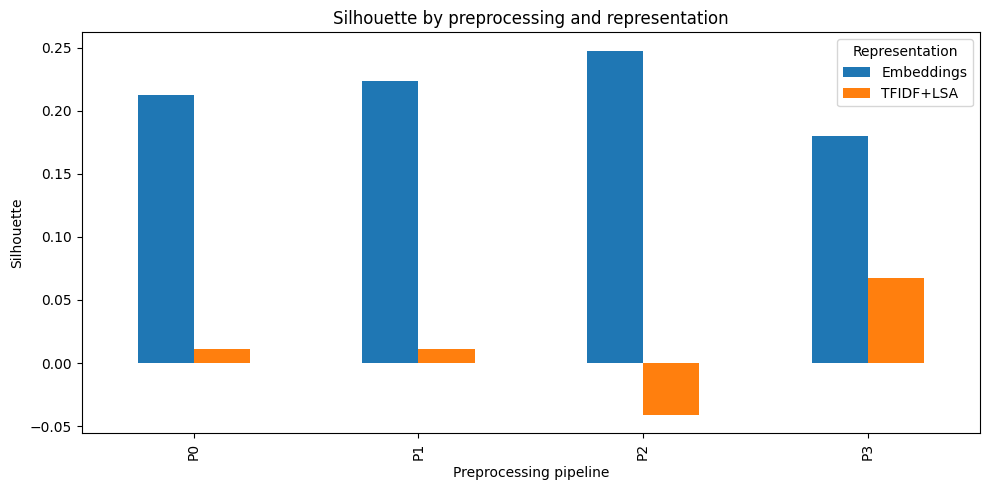

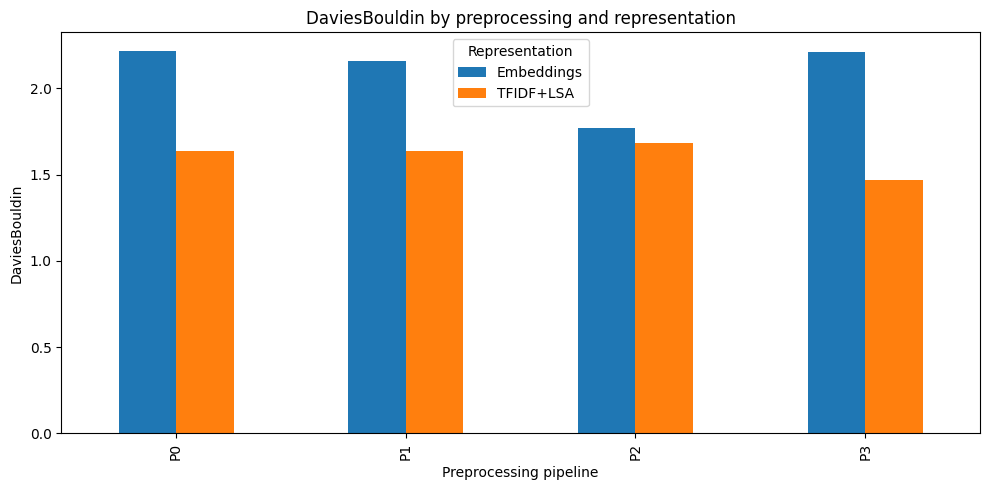

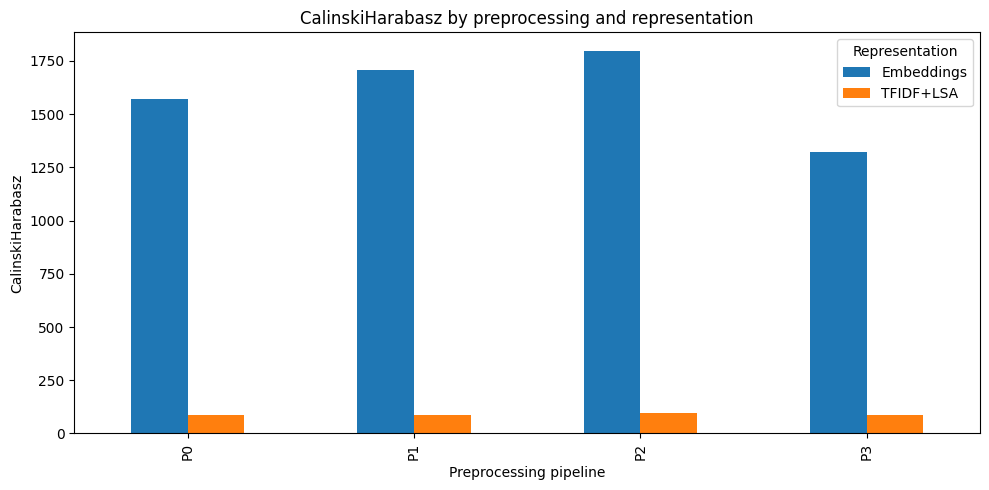

In [7]:
# Cell 7 — Visual comparison plots (clean and dissertation-ready)
def plot_metric(metric: str):
    pivot = results.pivot(index="Preprocessing", columns="Representation", values=metric).loc[["P0","P1","P2","P3"]]
    ax = pivot.plot(kind="bar", figsize=(10,5))
    ax.set_title(f"{metric} by preprocessing and representation")
    ax.set_xlabel("Preprocessing pipeline")
    ax.set_ylabel(metric)
    ax.legend(title="Representation")
    plt.tight_layout()
    plt.show()

plot_metric("Silhouette")
plot_metric("DaviesBouldin")
plot_metric("CalinskiHarabasz")


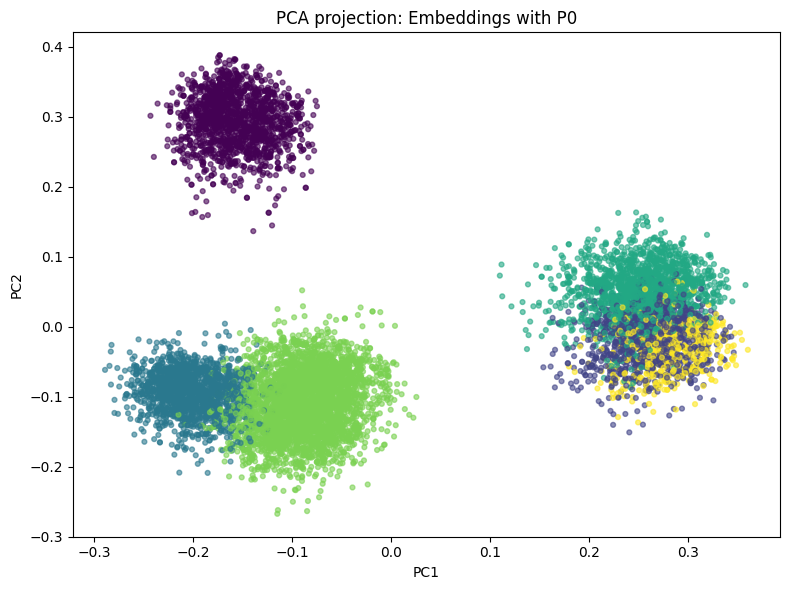

In [8]:

# Cell 8 — 2D PCA scatter for one configuration (useful for your discussion chapter)

rep_name, p_name = "Embeddings", "P0"  # change to inspect other settings
X_2d, labels = all_outputs[(rep_name, p_name)]

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, s=12, alpha=0.6)
plt.title(f"PCA projection: {rep_name} with {p_name}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


In [9]:
# Cell 9 — Export results table for dissertation appendix

results.to_csv("clustering_preprocessing_comparison.csv", index=False)
results


,Representation,Preprocessing,Silhouette,DaviesBouldin,CalinskiHarabasz
6,Embeddings,P2,0.247641,1.769358,1794.465088
5,Embeddings,P1,0.223378,2.156643,1705.956055
4,Embeddings,P0,0.212806,2.213132,1568.857910
7,Embeddings,P3,0.179953,2.209702,1324.245483
3,TFIDF+LSA,P3,0.067258,1.469552,86.811566
0,TFIDF+LSA,P0,0.010956,1.633592,86.216582
1,TFIDF+LSA,P1,0.010956,1.633592,86.216582
2,TFIDF+LSA,P2,-0.041326,1.682323,96.175683
